In [ ]:
from vita_toolkit import depth_rgb_to_pcd, project_pc_to_bev
from vita_toolkit.point_cloud.viz import visualize_point_cloud, visualize_bev
from vita_toolkit.lmdb_reader import simple_read_example, PureLMDBReader
import numpy as np 
import pickle
import os
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [378]:
# read from file system 
from vita_toolkit.filesystem_reader import FilesystemReader
file_path = "/home/heng.li/repo/vita-agent/test_data"
reader = FilesystemReader(file_path)



Found 59 timestamps in /home/heng.li/repo/vita-agent/test_data


In [379]:
test_datas = list(reader.iterate_frames())
test_data = test_datas[15]

In [380]:
test_data

{'timestamp': '1749813613954140855',
 'point_clouds': array([[-2.14232236e-01, -8.53524745e-01,  1.53588975e-04],
        [-2.13084504e-01, -8.44580710e-01,  4.07727733e-02],
        [-5.13290703e-01, -2.03897691e+00,  1.99123725e-01],
        ...,
        [-4.81492341e-01, -3.57529187e+00,  2.49799848e+00],
        [-4.85239506e-01, -3.58890867e+00,  2.77089810e+00],
        [-4.77235585e-01, -3.52045512e+00,  3.00328922e+00]],
       shape=(9528, 3)),
 'depth': None,
 'left_image': array([[[111, 112, 116],
         [111, 112, 116],
         [111, 112, 116],
         ...,
         [128, 127, 125],
         [128, 127, 125],
         [128, 127, 125]],
 
        [[111, 112, 116],
         [111, 112, 116],
         [111, 112, 116],
         ...,
         [128, 127, 125],
         [128, 127, 125],
         [128, 127, 125]],
 
        [[111, 112, 116],
         [111, 112, 116],
         [111, 112, 116],
         ...,
         [128, 127, 125],
         [128, 127, 125],
         [128, 127, 12

In [381]:
from PIL import Image
# load image as PIL from numpy arrary 
def numpy_to_pil(image: np.ndarray):
    print(image.shape)
    numpy_image = np.ascontiguousarray(image)
    # to pil 
    image = Image.fromarray(image)
    return image, numpy_image



In [382]:
pil_image, numpy_image = numpy_to_pil(test_data["left_image"])

(1080, 1920, 3)


In [383]:
import requests
from PIL import Image
import torch
from transformers import DepthProImageProcessorFast, DepthProForDepthEstimation
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


image = pil_image

image_processor = DepthProImageProcessorFast.from_pretrained("apple/DepthPro-hf")
model = DepthProForDepthEstimation.from_pretrained("apple/DepthPro-hf").to(device)

inputs = image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

post_processed_output = image_processor.post_process_depth_estimation(
    outputs, target_sizes=[(image.height, image.width)],
)

field_of_view = post_processed_output[0]["field_of_view"]
focal_length = post_processed_output[0]["focal_length"]
depth = post_processed_output[0]["predicted_depth"]
numpy_depth = depth.detach().cpu().numpy()
inverse_depth = 1 / numpy_depth
# Visualize inverse depth instead of depth, clipped to [0.1m;250m] range for better visualization.
max_invdepth_vizu = min(inverse_depth.max(), 1 / 0.1)
min_invdepth_vizu = max(1 / 250, inverse_depth.min())
inverse_depth_normalized = (inverse_depth - min_invdepth_vizu) / (
    max_invdepth_vizu - min_invdepth_vizu
)
# Save as color-mapped "turbo" jpg image.
cmap = plt.get_cmap("turbo")
color_depth = (cmap(inverse_depth_normalized)[..., :3] * 255).astype(np.uint8)
depth = Image.fromarray(color_depth)

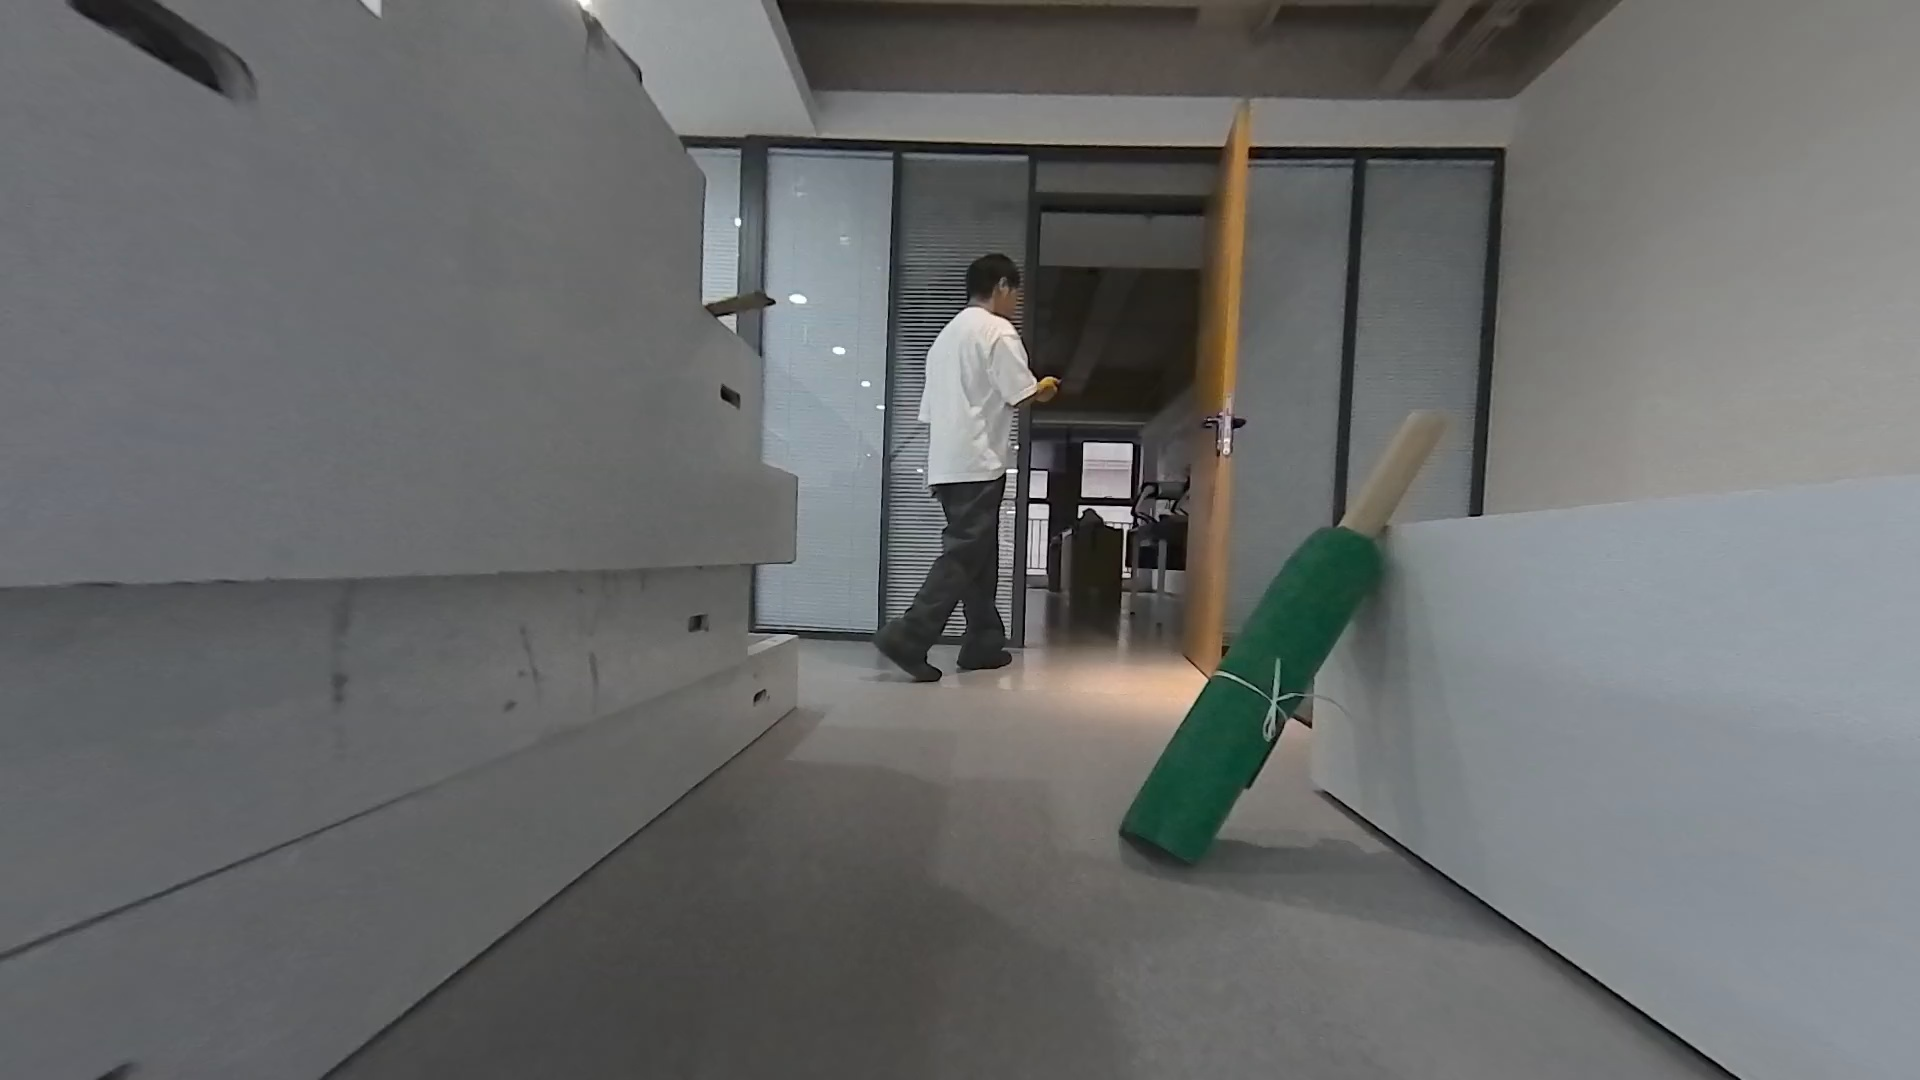

In [384]:
image

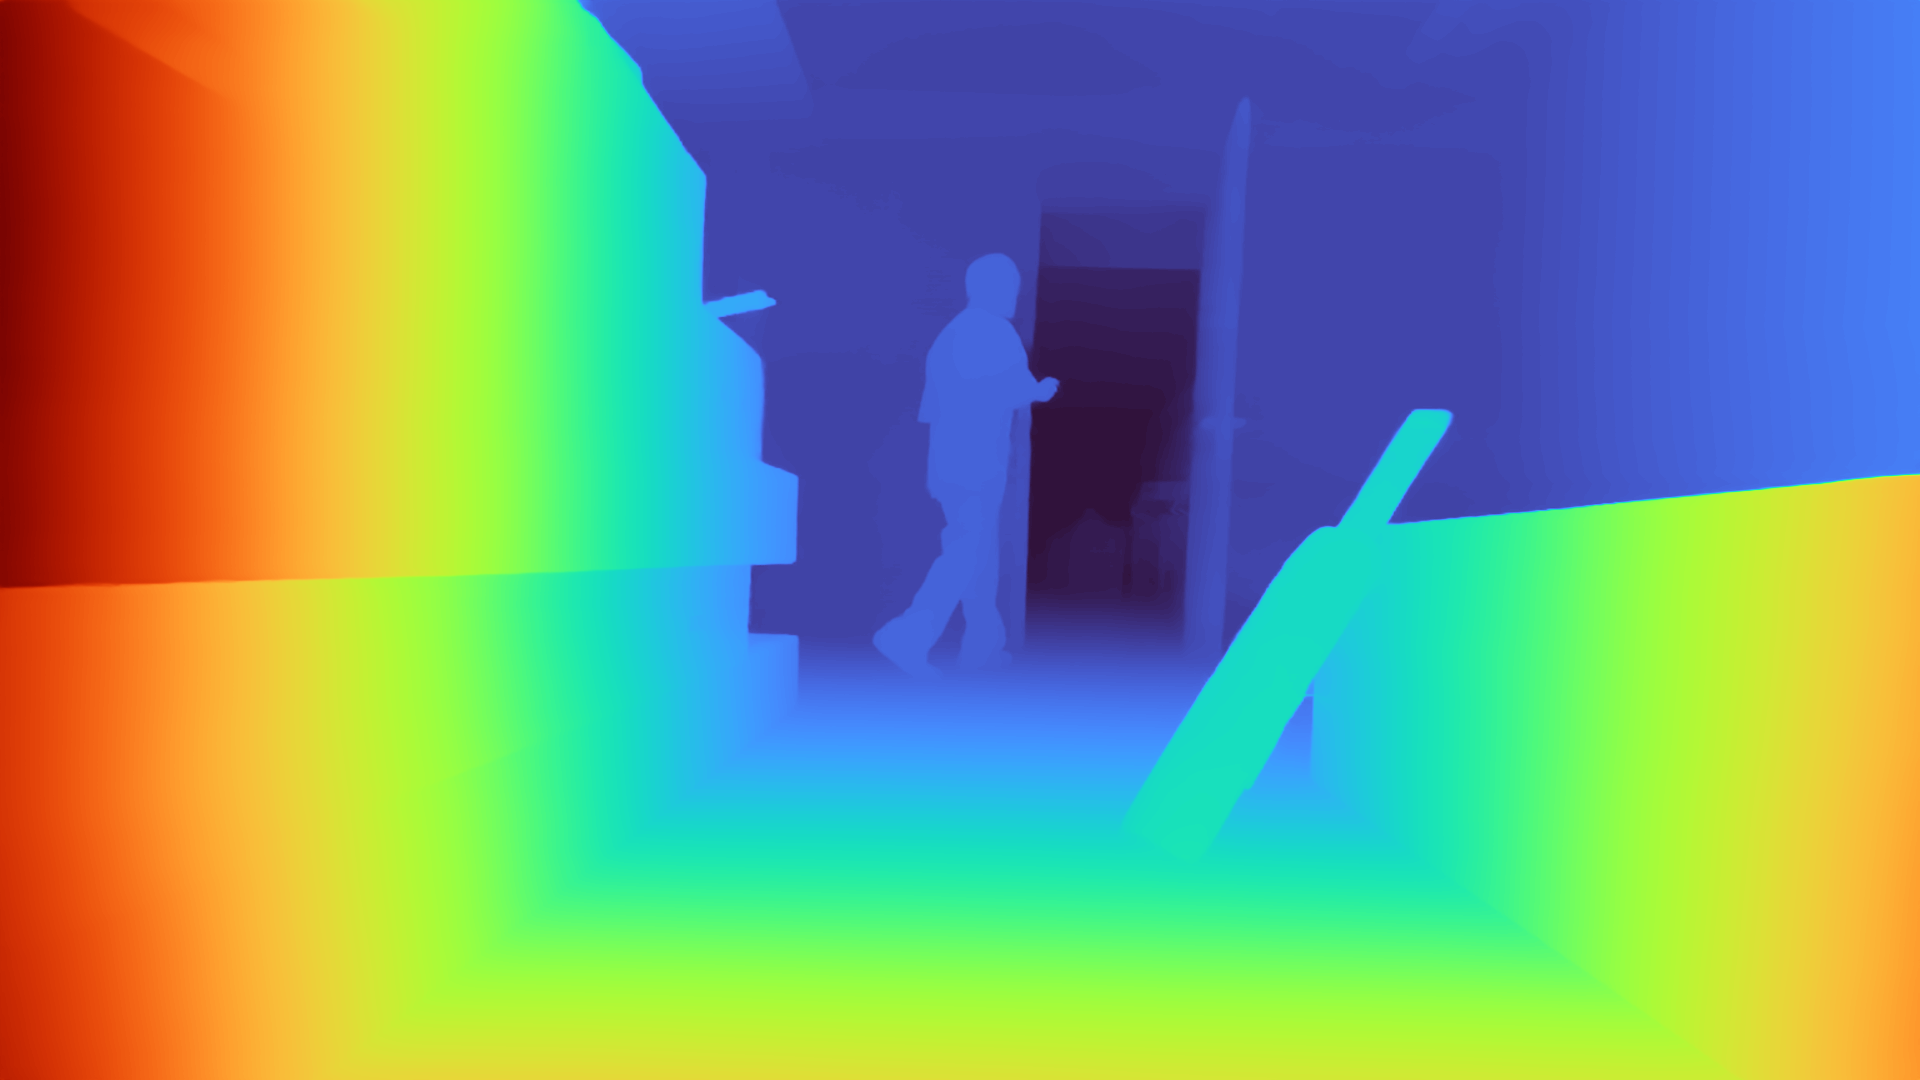

In [385]:
depth

In [386]:
numpy_depth

array([[0.75869256, 0.74852973, 0.74276423, ..., 3.6777446 , 3.543276  ,
        3.3021262 ],
       [0.7365134 , 0.73120624, 0.7284291 , ..., 3.6900933 , 3.6881452 ,
        3.7114766 ],
       [0.7202785 , 0.71863186, 0.71770775, ..., 3.7195182 , 3.715228  ,
        3.7139888 ],
       ...,
       [0.767224  , 0.7685274 , 0.76882106, ..., 0.9652762 , 0.9628716 ,
        0.95850074],
       [0.77155226, 0.7728894 , 0.7725182 , ..., 0.96871716, 0.9693477 ,
        0.96844715],
       [0.76375175, 0.77241224, 0.776121  , ..., 0.9736476 , 0.97967005,
        0.986696  ]], shape=(1080, 1920), dtype=float32)

In [387]:
import numpy as np

# Camera calibration parameters
intrinsic_params_rgb = {
    "fx": 721.744,
    "fy": 721.744, 
    "cx": 972.885,
    "cy": 590.376
}

extrinsic_matrix = np.array(
    [
        [-0.0130459, 0.999647, 0.0231345, 0.0351892],
        [0.065793, 0.0239446, -0.997545, 0.00365625],
        [-0.997748, -0.0114917, -0.0660821, -0.259888],
        [0, 0, 0, 1],
    ]
)

extrinsic_params = {"data": extrinsic_matrix}

# Debug: Check shapes and depth value ranges
print("Original RGB image shape:", test_data["left_image"].shape)
print("Depth image shape:", numpy_depth.shape)
print("Depth value range:", numpy_depth.min(), "to", numpy_depth.max())

# The RGB image needs to be properly formatted for Open3D
# It should be (height, width, 3) not (3, height, width)
rgb_image = test_data["left_image"]
if rgb_image.shape[0] == 3:  # If channels are first
    rgb_image = np.transpose(rgb_image, (1, 2, 0))  # Move channels to last
    
print("Corrected RGB image shape:", rgb_image.shape)

# Fix 1: Ensure depth is in millimeters and within reasonable range
# DepthPro outputs are in meters, convert to millimeters for Open3D
depth_mm = numpy_depth * 1000

# Fix 2: Clamp depth values to reasonable range (0.1m to 5m)
depth_mm = np.clip(depth_mm, 100, 20000)  # 0.1m to 5m in mm

# Fix 3: Ensure depth is uint16 format (preferred by Open3D)
depth_mm = depth_mm.astype(np.uint16)

print("Processed depth range:", depth_mm.min(), "to", depth_mm.max(), "mm")

# Call the function with corrected depth
points, colors = depth_rgb_to_pcd(
    depth=depth_mm, 
    intrinsic=intrinsic_params_rgb,
    extrinsic=extrinsic_params,
    rgb=numpy_image,
    depth_rgb_scale=1.0
)

Original RGB image shape: (1080, 1920, 3)
Depth image shape: (1080, 1920)
Depth value range: 0.70054877 to 18.883322
Corrected RGB image shape: (1080, 1920, 3)
Processed depth range: 700 to 18883 mm


In [388]:
points


array([[-1.04284141, -1.08320471,  0.53044281],
       [-1.03251513, -1.06838304,  0.52327967],
       [-1.02632451, -1.05909219,  0.51899096],
       ...,
       [-1.203158  ,  1.23867528, -0.70630297],
       [-1.20899731,  1.24790538, -0.71053856],
       [-1.21580718,  1.25846728, -0.7154849 ]], shape=(2073600, 3))

In [389]:
colors

array([[0.43529412, 0.43921569, 0.45490196],
       [0.43529412, 0.43921569, 0.45490196],
       [0.43529412, 0.43921569, 0.45490196],
       ...,
       [0.54117647, 0.56862745, 0.6       ],
       [0.54509804, 0.57254902, 0.60392157],
       [0.54509804, 0.57254902, 0.60392157]], shape=(2073600, 3))

In [390]:
import rerun as rr
import matplotlib
cmap = matplotlib.colormaps["turbo_r"]
norm = matplotlib.colors.Normalize(
vmin=2.0,
vmax=15,
)
# Now we viz use rerun. 
rr.init("vita_toolkit")
rr.connect_grpc(url="rerun+http://127.0.0.1:9876/proxy")
# For point cloud 


In [ ]:
from vita_toolkit.point_cloud.img_to_pc import pcd_to_camera_coordinate
from vita_toolkit.point_cloud.pc_to_bev import filter_pcd
t = np.array([-0.0613157 -0.0842516 -0.112423])
# pc_range = np.array([-6.4, -6.4, -2.0, 6.4, 6.4, 2.8])
#lcd = filter_pcd(test_data["point_clouds"][:, :3], pc_range)
before_lidar = test_data["point_clouds"][:, :3]
before_lidar[:, 1] = before_lidar[:, 1] * -1
lidar_pcd = pcd_to_camera_coordinate(before_lidar, extrinsic_params)


In [392]:
# transpose to corrent cooridnates 
# Current z is the y. Current y is x. Current x is z. 
# Transpose axes: z -> y, y -> x, x -> z
# Original lidar_pcd shape: (N, 3)
# New order: [2, 0, 1] (x, y, z) -> (z, x, y)
lidar_pcd = lidar_pcd[:, [2, 0, 1]]
lidar_pcd[:, 2] = lidar_pcd[:, 2] * -1

In [393]:
np.max(lidar_pcd[:, 2], axis=-1)

np.float64(3.195889422313118)

In [394]:
point_colors = cmap(norm(np.linalg.norm(lidar_pcd[:, :3], axis=1)))
rr.log(
    "/world/ego/lidar", 
    rr.Points3D(
        positions=lidar_pcd[:, :3], 
        colors=point_colors
    ),
)

In [ ]:
# align with pcd 
from vita_toolkit.point_cloud.depht_lidar_matching import align_depth_lidar
scale_factor, valid_depth_pairs, final_lidar_depths = align_depth_lidar(numpy_depth, lidar_pcd[:, :3], intrinsic_params_rgb)

In [396]:
len(final_lidar_depths), len(valid_depth_pairs)

(544, 544)

In [397]:
scale_factor

0.5858598576132319

In [398]:
point_colors = cmap(norm(np.linalg.norm(points[:, :3], axis=1)))
points[:, 0] = points[:, 0] * -1
points[:, 1] = points[:, 1] * -1
rr.log(
    "/world/ego/depth_lidar", 
    rr.Points3D(
        positions=points[:, :3] * scale_factor,
        colors=point_colors
    ),
)

## Now project to BEV view 

In [399]:
pc_ranges = np.array([-6.4, -6.4, -2.0, 6.4, 6.4, 2.8])
voxel_size = np.array([0.2, 0.2, 8.0])
bev_size = project_pc_to_bev(points, pc_ranges, voxel_size, pc_ranges)

In [400]:
# Get the first batch and sum across z dimension to get 2D occupancy
occupancy_2d = np.sum(bev_size[0], axis=0)  # Shape: (ny, nx)

# Find non-zero (occupied) cells
occupied_indices = np.where(occupancy_2d > 0)

# Randomly sample from occupied cells
random_idx = np.random.randint(len(occupied_indices[0]))
y_idx, x_idx = occupied_indices[0][random_idx], occupied_indices[1][random_idx]

# Convert grid indices to world coordinates
x_world = pc_ranges[0] + (x_idx + 0.5) * voxel_size[0]
y_world = pc_ranges[1] + (y_idx + 0.5) * voxel_size[1]

In [401]:
x_world

np.float64(4.1)

In [402]:
y_world

np.float64(1.6999999999999993)

In [ ]:
# Import the new depth-lidar alignment functions
from vita_toolkit.point_cloud.depht_lidar_matching import align_depth_lidar, DepthLidarSolver, AlignmentResult
import matplotlib.pyplot as plt
import pandas as pd
import time

In [404]:
# Benchmark different depth-lidar alignment methods
print("=" * 60)
print("DEPTH-LIDAR ALIGNMENT BENCHMARK")
print("=" * 60)

# Define methods to benchmark
methods = [
    {"name": "Least Squares", "method": "least_squares"},
    {"name": "Median Ratio", "method": "median_ratio"},
    {"name": "Robust Least Squares (Huber)", "method": "robust_least_squares", "robust_loss": "huber"},
    {"name": "Robust Least Squares (Soft L1)", "method": "robust_least_squares", "robust_loss": "soft_l1"},
    {"name": "RANSAC", "method": "ransac"},
    {"name": "Adaptive Scaling", "method": "adaptive_neighborhood"}
]

# Store results for comparison
benchmark_results = []

for method_config in methods:
    method_name = method_config["name"]
    method = method_config["method"]
    
    print(f"\n🔍 Testing {method_name}...")
    
    # Time the alignment
    start_time = time.time()
    

    # Create solver with reasonable parameters
    solver = DepthLidarSolver(outlier_threshold=0.2, max_iterations=100)
    
    # Prepare solver arguments
    solver_args = {
        "depth_map": numpy_depth,
        "lidar_points": lidar_pcd,
        "intrinsic_params": intrinsic_params_rgb,
        "method": method
    }
    
    # Add robust loss if specified
    if "robust_loss" in method_config:
        solver_args["robust_loss"] = method_config["robust_loss"]
    
    # Run alignment
    result = solver.solve(**solver_args)
    
    # Calculate execution time
    execution_time = time.time() - start_time
    
    # Store results
    benchmark_results.append({
        "Method": method_name,
        "Scale Factor": result.scale_factor,
        "RMSE": result.rmse,
        "Mean Error": result.mean_error,
        "Median Error": result.median_error,
        "Std Error": result.std_error,
        "Correspondences": result.num_correspondences,
        "Outlier Ratio": result.outlier_ratio,
        "Converged": result.converged,
        "Iterations": result.iterations,
        "Time (s)": execution_time
    })
    
    print(f"   ✅ Scale factor: {result.scale_factor:.4f}")
    print(f"   📊 RMSE: {result.rmse:.4f}")
    print(f"   🎯 Mean error: {result.mean_error:.4f}")
    print(f"   📈 Outlier ratio: {result.outlier_ratio:.2%}")
    print(f"   🔢 Correspondences: {result.num_correspondences}")
    print(f"   ⏱️ Time: {execution_time:.4f}s")

print("\n" + "=" * 60)
print("BENCHMARK SUMMARY")
print("=" * 60)

DEPTH-LIDAR ALIGNMENT BENCHMARK

🔍 Testing Least Squares...
   ✅ Scale factor: 0.5859
   📊 RMSE: 1.3492
   🎯 Mean error: -0.7552
   📈 Outlier ratio: 0.00%
   🔢 Correspondences: 544
   ⏱️ Time: 0.0006s

🔍 Testing Median Ratio...
   ✅ Scale factor: 1.5346
   📊 RMSE: 3.6317
   🎯 Mean error: 2.0230
   📈 Outlier ratio: 0.00%
   🔢 Correspondences: 544
   ⏱️ Time: 0.0004s

🔍 Testing Robust Least Squares (Huber)...
   ✅ Scale factor: 0.5508
   📊 RMSE: 1.3550
   🎯 Mean error: -0.8579
   📈 Outlier ratio: 89.89%
   🔢 Correspondences: 544
   ⏱️ Time: 0.0022s

🔍 Testing Robust Least Squares (Soft L1)...
   ✅ Scale factor: 0.5566
   📊 RMSE: 1.3532
   🎯 Mean error: -0.8409
   📈 Outlier ratio: 89.71%
   🔢 Correspondences: 544
   ⏱️ Time: 0.0014s

🔍 Testing RANSAC...
   ✅ Scale factor: 0.6224
   📊 RMSE: 1.3554
   🎯 Mean error: -0.6482
   📈 Outlier ratio: 85.48%
   🔢 Correspondences: 544
   ⏱️ Time: 0.0036s

🔍 Testing Adaptive Scaling...


TypeError: AlignmentResult.__init__() got an unexpected keyword argument 'local_scales'

In [ ]:
# Create DataFrame for better visualization
df_results = pd.DataFrame(benchmark_results)
print(df_results.to_string(index=False))

# Find best method based on RMSE
successful_results = df_results[df_results['RMSE'].notna()]
if not successful_results.empty:
    best_method = successful_results.loc[successful_results['RMSE'].idxmin()]
    print(f"\n🏆 Best method: {best_method['Method']} (RMSE: {best_method['RMSE']:.4f})")
    
    # Use best method for further analysis
    best_solver = DepthLidarSolver(outlier_threshold=0.2, max_iterations=100)
    best_result = best_solver.solve(
        depth_map=numpy_depth,
        lidar_points=lidar_pcd,
        intrinsic_params=intrinsic_params_rgb,
        method=best_method['Method'].lower().replace(' ', '_').replace('(', '').replace(')', '').replace('huber', 'robust_least_squares')
    )
    
    print(f"\n📈 Detailed metrics for {best_method['Method']}:")
    metrics = best_solver.evaluate_alignment(best_result)
    for key, value in metrics.items():
        print(f"   {key}: {value:.4f}")
else:
    print("\n❌ No successful alignments found!")

                        Method  Scale Factor     RMSE  Mean Error  Median Error  Std Error  Correspondences  Outlier Ratio  Converged  Iterations  Time (s)
                 Least Squares      0.585860 1.349207   -0.755171     -1.237786   1.118068              544       0.000000       True           0  0.002350
                  Median Ratio      1.534644 3.631741    2.023008      0.000173   3.016120              544       0.000000       True           0  0.000677
  Robust Least Squares (Huber)      0.550780 1.354954   -0.857888     -1.281238   1.048775              544       0.898897       True           4  0.017128
Robust Least Squares (Soft L1)      0.556579 1.353214   -0.840910     -1.274056   1.060216              544       0.897059       True           4  0.001766
                        RANSAC      0.622382 1.355435   -0.648230     -1.192547   1.190380              544       0.854779       True         100  0.003806

🏆 Best method: Least Squares (RMSE: 1.3492)

📈 Detailed metrics